<a href="https://colab.research.google.com/github/DmytroBuzanov/DS-ML/blob/main/Training_model_7_routers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import SGD  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/wifi_localization.txt', names=['WS1',	'WS2',	'WS3',	'WS4',	'WS5',	'WS6',	'WS7',	'Class'], sep='\t')


In [ ]:
df.values[:, :7]

array([[-64, -56, -61, ..., -71, -82, -81],
       [-68, -57, -61, ..., -71, -85, -85],
       [-63, -60, -60, ..., -76, -85, -84],
       ...,
       [-62, -59, -46, ..., -45, -87, -88],
       [-62, -58, -52, ..., -41, -90, -85],
       [-59, -50, -45, ..., -45, -88, -87]])

**Розбиття датасету на 3 вибірки**

In [ ]:
num_classes = 4
X_train, X_test, y_train, y_test = train_test_split(df.values[:, :7],    
                                                    df.values[:, -1] - 1, 
                                                    test_size=0.25,
                                                    random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train,                         
                                                y_train, 
                                                test_size=0.10, 
                                                random_state=20)

print(X_train.shape, X_val.shape, X_test.shape)

(1350, 7) (150, 7) (500, 7)


**Нормалізація**

In [ ]:
scaler = StandardScaler()
print(scaler.fit(X_train))

X_train_scaled = scaler.transform(X_train)                        # Standard Score
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)



StandardScaler(copy=True, with_mean=True, with_std=True)


In [ ]:
def create_model(learn_rate=0.01, 
                 momentum=0,
                 k_l1=0, 
                 k_l2=0,
                 neurons_1=1, 
                 neurons_2=1):
  model = Sequential([
    Dense(neurons_1, input_shape=(7,), activation='relu',kernel_regularizer=regularizers.l1_l2(k_l1, k_l2)),
    # Dense(neurons, activation='relu',kernel_regularizer=regularizers.l1(k_l1)),
    Dense(neurons_2, activation='relu',kernel_regularizer=regularizers.l1_l2(k_l1, k_l2)),
    Dense(4, activation='softmax',kernel_regularizer=regularizers.l1_l2(k_l1, k_l2))])


  

  model.compile(optimizer=SGD(lr=learn_rate, momentum=momentum),              
                loss='sparse_categorical_crossentropy', 
                metrics=['sparse_categorical_accuracy'])
                               
  return model

In [ ]:
cross_val_model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=32, verbose=0)

**Early Stopping**

In [ ]:
early_Stop = EarlyStopping(monitor='val_loss',                                  # Early Stopping Regularization 
                           patience=20,
                           verbose=1,                        
                           restore_best_weights=True)

In [ ]:
model = create_model(k_l1=0.01, learn_rate=0.01, momentum=0.8, neurons_1=6, neurons_2=9)

history = model.fit(X_train_scaled, y_train, epochs=1000, callbacks = [early_Stop], validation_data=(X_val_scaled, y_val), verbose=0)

model.evaluate(X_train_scaled, y_train), model.evaluate(X_val_scaled, y_val), model.evaluate(X_test_scaled, y_test)

Restoring model weights from the end of the best epoch.
Epoch 00339: early stopping
16/16 [==============================] - 0s 2ms/step - loss: 0.2750 - sparse_categorical_accuracy: 0.9800


([0.26155877113342285, 0.9896296262741089],
 [0.26281487941741943, 0.9800000190734863],
 [0.2749596834182739, 0.9800000190734863])

**Перехресна перевірка: Grid Search**

In [ ]:
grid = GridSearchCV(estimator=cross_val_model, verbose=0, 
                                                                                
                    scoring='accuracy',
                    param_grid={'k_l1':[0.01],                                  
                                'learn_rate':[0.01],                             
                                'momentum':[0.8],                               
                                'neurons_1':[6],                                
                                'neurons_2':[9],                                
                                },                           
                    cv = 5) 

In [ ]:
grid_result = grid.fit(X_train_scaled, y_train, callbacks = [early_Stop], validation_data=(X_val_scaled, y_val), verbose=0)

print('The parameters of the best model are: ')
print(grid_result.best_params_)

best_model = grid_result.best_estimator_.model
best_model.evaluate(X_test_scaled, y_test)

Restoring model weights from the end of the best epoch.
Epoch 00553: early stopping
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Restoring model weights from the end of the best epoch.
Epoch 00553: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00438: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00457: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00543: early stopping
The parameters of the best model are: 
{'k_l1': 0.01, 'learn_rate': 0.01, 'momentum': 0.8, 'neurons_1': 6, 'neurons_2': 9}
16/16 [==============================] - 0s 2ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.9800


[0.2681058347225189, 0.9800000190734863]

**Візуалізація навчання моделі**

In [ ]:
print(history.history.keys())
print(history.history['sparse_categorical_accuracy'])
print(history.history['val_sparse_categorical_accuracy'])

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
[0.529629647731781, 0.7429629564285278, 0.8748148083686829, 0.9392592310905457, 0.9592592716217041, 0.9681481719017029, 0.9733333587646484, 0.9733333587646484, 0.9748148322105408, 0.9762963056564331, 0.9777777791023254, 0.9777777791023254, 0.9800000190734863, 0.9814814925193787, 0.9792592525482178, 0.9807407259941101, 0.9800000190734863, 0.982962965965271, 0.982962965965271, 0.9844444394111633, 0.9844444394111633, 0.9822221994400024, 0.9837037324905396, 0.9844444394111633, 0.9866666793823242, 0.9822221994400024, 0.9859259128570557, 0.9859259128570557, 0.9859259128570557, 0.9844444394111633, 0.9859259128570557, 0.9859259128570557, 0.9837037324905396, 0.9866666793823242, 0.9851852059364319, 0.9859259128570557, 0.9844444394111633, 0.9859259128570557, 0.9851852059364319, 0.9851852059364319, 0.9859259128570557, 0.9851852059364319, 0.9859259128570557, 0.9851852059364319, 0.9859259128570557, 0.98

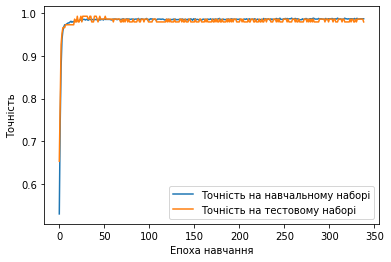

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Точність на навчальному наборі')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Точність на тестовому наборі')
plt.xlabel('Епоха навчання')
plt.ylabel('Точність')
plt.legend()
plt.show()

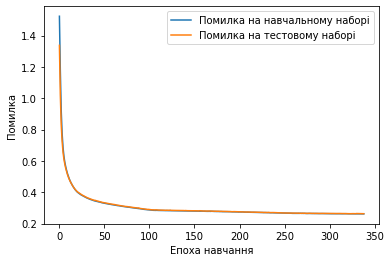

In [ ]:
plt.plot(history.history['loss'], label='Помилка на навчальному наборі')
plt.plot(history.history['val_loss'], label='Помилка на тестовому наборі')
plt.xlabel('Епоха навчання')
plt.ylabel('Помилка')
plt.legend()
plt.show()

**Матриця помилок**

In [ ]:
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
confusion_matrix(y_test, y_pred)

array([[134,   0,   0,   0],
       [  0, 130,   2,   0],
       [  1,   4, 106,   1],
       [  0,   0,   2, 120]])

<Figure size 432x288 with 0 Axes>

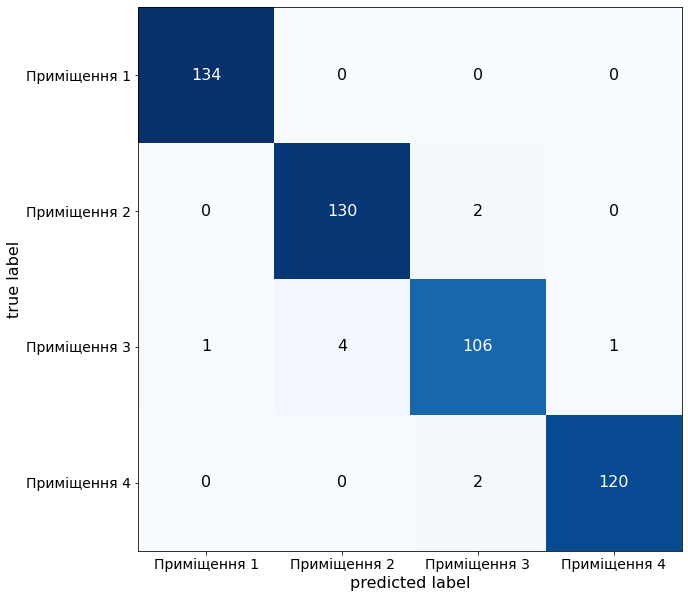

In [ ]:
plt.rcParams.update({'font.size': 16})

cm  = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(10, 10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['Приміщення 1', 'Приміщення 2', 'Приміщення 3', 'Приміщення 4'], fontsize=14)
plt.yticks(range(4), ['Приміщення 1', 'Приміщення 2', 'Приміщення 3', 'Приміщення 4'], rotation=0, fontsize=14) 
plt.show()

**Classification report**

In [ ]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       134
           1       0.97      0.98      0.98       132
           2       0.96      0.95      0.95       112
           3       0.99      0.98      0.99       122

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

